# Capstone 2 - Pre-Processing
# WESAD dataset (Wearable Stress and Affect Detection)
## Goals of this notebook:
### Separate experimental task label into y, and send the rest to X
* Theoretically, behavioral processes (movement?) and autonomic reactivity are parallel, while cognitive emotional evaluations are partially downstream from both of these and may be partially independent.
* Perhaps the second and third models could have arousal and valence ratings as the target (y2, y3)?
### Make sure y (task) is a categorical variable.
### For arousal and valence in models 2 & 3, they should be ordinal target variables.
### Create dummy features for experimental manipulation (meditation before or after social stress), and for subject level variables (had coffee or other stimulants, exercised that day, etc.)
### Standardize all non-categorical features
### Conduct train-test split. Stratify by subject ID and by experimental task to ensure counterbalancing?
### Document thoroughly


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# First, load the data that were transformed in Exploratory Data Analysis and in Data Wrangling

In [15]:
# This data has the device recordings and the questionnaire data for Valence and Arousal
data_root_path  = "D:/Springboard/Capstone2/WESAD/Capstone2/data/processed/Preprocessing/"
physio_Q_df = pd.read_csv(data_root_path + "BOTH_after_EDA_select_vars.csv", usecols=[i for i in range(1,12)])
print(physio_Q_df.info())
display(physio_Q_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Condition                    75 non-null     object 
 1   Subject_ID                   75 non-null     object 
 2   ACC_chest_energy_per_minute  75 non-null     float64
 3   ACC_wrist_energy_per_minute  75 non-null     float64
 4   Arousal                      75 non-null     float64
 5   EMG_energy_per_minute        75 non-null     float64
 6   GSR_rate                     75 non-null     float64
 7   HRV_RMSSD                    75 non-null     float64
 8   HR_avg                       75 non-null     float64
 9   Resp_autocorr_energy         75 non-null     float64
 10  Valence                      75 non-null     float64
dtypes: float64(9), object(2)
memory usage: 6.6+ KB
None


,Condition,Subject_ID,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Arousal,EMG_energy_per_minute,GSR_rate,HRV_RMSSD,HR_avg,Resp_autocorr_energy,Valence
0,AMUSEMENT,S10,1.570970,3.772454,2.0,-1.250828,0.645164,0.045500,76.685501,39.833505,8.0
1,AMUSEMENT,S11,1.590859,4.897050,3.0,-1.150267,2.608706,0.067619,75.318147,39.887777,8.0
2,AMUSEMENT,S13,1.702579,5.012727,4.0,-0.843758,1.413618,0.042670,87.160320,39.869489,8.0
3,AMUSEMENT,S14,1.689439,4.337537,2.0,-1.142540,2.096774,0.022869,83.590056,39.853686,7.0
4,AMUSEMENT,S15,1.626402,4.292786,5.0,-1.106505,1.774200,0.049063,77.132518,39.908319,7.0


In [60]:
#Subject Intake Info
subj_info_file_list = glob("D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/S*_info.json")
subj_info_dict = { path.split('\\')[-1].split('_')[-2] : path for path in subj_info_file_list}
#subj_info_dict

In [74]:
# Get subject-level variables (collected at intake)

outer_list = []

subjects_getting_meditation_before_stress = {'S4', 'S5', 'S7', 'S8', 'S10', 'S13', 'S15', 'S17'} #subset of subjects

for Subj_ID, json_path in subj_info_dict.items(): #iterate over all 15 subjects
    
    info_dict = {'Subj_ID':Subj_ID} #prepare dictionary for each subject
    
    #print(Subj_ID,'\n')
    with open(subj_info_dict[Subj_ID], 'r') as file: # Read json file and convert string to DataFrame
        lines = file.readlines()
        info_str = lines[0] # Extracts dictionary from json
        info_str_list = info_str.split('{')[-1].split('}')[0].split('\",')
        #print(info_str_list)
        
        for item in info_str_list:
            key, value = item.split(':')[0].split('\"')[1], item.split(':')[1].split('\"')[1]
            info_dict[key] = value

    #print('\n')
    #for k, v in info_dict.items(): 
    #    print(k,':', v)
    #print('\n')
    
    #Set columns of outer DataFrame
    inner_df = pd.DataFrame(pd.Series(info_dict)).T
    #display(inner_df)
    #print('\n')
    
    inner_df = inner_df.replace('NO', 0).replace('YES', 1).replace('-\\n', np.nan)
    
    inner_df['meditation_before_stress'] = int(Subj_ID in subjects_getting_meditation_before_stress) #binary var
    
    outer_list.append( inner_df )

info_df = pd.concat(outer_list)

numeric_cols = [1, 2, 3, 6, 7, 8, 9, 10, 11, 13]
info_df.iloc[:,numeric_cols] = info_df.iloc[:,numeric_cols].astype('int')
print(info_df.info())
display(info_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 0
Data columns (total 15 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Subj_ID                                    15 non-null     object
 1   Age                                        15 non-null     int32 
 2   Height (cm)                                15 non-null     int32 
 3   Weight (kg)                                15 non-null     int32 
 4   Gender                                     15 non-null     object
 5   Dominant hand                              15 non-null     object
 6   Did you drink coffee today                 15 non-null     int32 
 7   Did you drink coffee within the last hour  15 non-null     int32 
 8   Did you do any sports today                15 non-null     int32 
 9   Are you a smoker                           15 non-null     int32 
 10  Did you smoke within the last hour       

,Subj_ID,Age,Height (cm),Weight (kg),Gender,Dominant hand,Did you drink coffee today,Did you drink coffee within the last hour,Did you do any sports today,Are you a smoker,Did you smoke within the last hour,Do you feel ill today,LINE_17,meditation_before_stress,LINE_18
0,S10,28,178,76,male,right,0,0,0,0,0,0,NaN,1,NaN
0,S11,26,171,54,female,right,1,0,0,0,0,0,NaN,0,NaN
0,S13,28,181,82,male,right,0,0,0,0,0,0,NaN,1,NaN
0,S14,27,180,80,male,right,0,0,0,0,0,0,NaN,0,NaN
0,S15,28,186,83,male,right,0,0,0,0,0,0,Subject didn't really believe the cover story ...,1,NaN
0,S16,24,184,69,male,right,0,0,0,0,0,0,Subject felt rather cold in the room where the...,0,NaN
0,S17,29,165,55,female,right,0,0,0,0,0,0,The RespiBAN temperature sensor was not fully ...,1,NaN
0,S2,27,175,80,male,right,0,0,0,0,0,0,The RespiBAN temperature sensor was not fully ...,0,NaN
0,S3,27,173,69,male,right,0,0,0,0,0,0,"During the baseline condition, the subject was...",0,Subject provided a valence label of 7 after th...
0,S4,25,175,90,male,right,0,0,0,0,0,0,NaN,1,NaN


### Get dummies for Gender and Dominant hand

In [76]:
info_df = pd.get_dummies(info_df, columns=['Gender', 'Dominant hand'], drop_first=True)
display(info_df.head())

,Subj_ID,Age,Height (cm),Weight (kg),Did you drink coffee today,Did you drink coffee within the last hour,Did you do any sports today,Are you a smoker,Did you smoke within the last hour,Do you feel ill today,LINE_17,meditation_before_stress,LINE_18,Gender_male,Dominant hand_right
0,S10,28,178,76,0,0,0,0,0,0,NaN,1,NaN,1,1
0,S11,26,171,54,1,0,0,0,0,0,NaN,0,NaN,0,1
0,S13,28,181,82,0,0,0,0,0,0,NaN,1,NaN,1,1
0,S14,27,180,80,0,0,0,0,0,0,NaN,0,NaN,1,1
0,S15,28,186,83,0,0,0,0,0,0,Subject didn't really believe the cover story ...,1,NaN,1,1


In [79]:
# Probably not going to include these in the model
info_df = info_df.drop(labels=['LINE_17','LINE_18'], axis=1)
display(info_df.head())

,Subj_ID,Age,Height (cm),Weight (kg),Did you drink coffee today,Did you drink coffee within the last hour,Did you do any sports today,Are you a smoker,Did you smoke within the last hour,Do you feel ill today,meditation_before_stress,Gender_male,Dominant hand_right
0,S10,28,178,76,0,0,0,0,0,0,1,1,1
0,S11,26,171,54,1,0,0,0,0,0,0,0,1
0,S13,28,181,82,0,0,0,0,0,0,1,1,1
0,S14,27,180,80,0,0,0,0,0,0,0,1,1
0,S15,28,186,83,0,0,0,0,0,0,1,1,1


# Merge DataFrames

In [80]:
all_df = pd.merge(left=physio_Q_df, right=info_df, left_on='Subject_ID', right_on='Subj_ID')
display(all_df.head())
print(all_df.info())

,Condition,Subject_ID,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Arousal,EMG_energy_per_minute,GSR_rate,HRV_RMSSD,HR_avg,Resp_autocorr_energy,...,Weight (kg),Did you drink coffee today,Did you drink coffee within the last hour,Did you do any sports today,Are you a smoker,Did you smoke within the last hour,Do you feel ill today,meditation_before_stress,Gender_male,Dominant hand_right
0,AMUSEMENT,S10,1.570970,3.772454,2.0,-1.250828,0.645164,0.045500,76.685501,39.833505,...,76,0,0,0,0,0,0,1,1,1
1,BASELINE,S10,1.617890,4.848515,2.0,-1.061692,1.474578,0.021324,99.254877,39.854762,...,76,0,0,0,0,0,0,1,1,1
2,MEDITATION 1,S10,1.567013,3.576312,1.0,-1.362529,0.452261,0.050339,76.575485,39.946422,...,76,0,0,0,0,0,0,1,1,1
3,MEDITATION 2,S10,1.579739,4.027915,2.0,-1.374448,2.864322,0.038401,77.959140,39.826178,...,76,0,0,0,0,0,0,1,1,1
4,SOCIAL STRESS,S10,1.780210,5.313077,8.0,-1.137323,7.034497,0.036197,108.885452,39.877123,...,76,0,0,0,0,0,0,1,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 24 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Condition                                  75 non-null     object 
 1   Subject_ID                                 75 non-null     object 
 2   ACC_chest_energy_per_minute                75 non-null     float64
 3   ACC_wrist_energy_per_minute                75 non-null     float64
 4   Arousal                                    75 non-null     float64
 5   EMG_energy_per_minute                      75 non-null     float64
 6   GSR_rate                                   75 non-null     float64
 7   HRV_RMSSD                                  75 non-null     float64
 8   HR_avg                                     75 non-null     float64
 9   Resp_autocorr_energy                       75 non-null     float64
 10  Valence                     

In [84]:
# Assert that Subject_ID and Subj_ID are equal:
all(all_df['Subject_ID'] == all_df['Subj_ID'])

True

In [86]:
# Drop excess Subj_ID column.
all_df = all_df.drop(['Subj_ID'], axis=1)
print(all_df.columns)

Index(['Condition', 'Subject_ID', 'ACC_chest_energy_per_minute',
       'ACC_wrist_energy_per_minute', 'Arousal', 'EMG_energy_per_minute',
       'GSR_rate', 'HRV_RMSSD', 'HR_avg', 'Resp_autocorr_energy', 'Valence',
       'Age', 'Height (cm)', 'Weight (kg)', 'Did you drink coffee today',
       'Did you drink coffee within the last hour',
       'Did you do any sports today', 'Are you a smoker',
       'Did you smoke within the last hour', 'Do you feel ill today',
       'meditation_before_stress', 'Gender_male', 'Dominant hand_right'],
      dtype='object')


In [139]:
#all_df.to_csv('after_preprocessing_df.csv')

# Divide into predictor variables and target variable
## Target variable (task condition) is categorical and as the target, does not need to be dummy coded.

In [90]:
y_col = all_df['Condition']
# Treating both meditation segments as similar. Merge them into the same category.
y_col = y_col.replace('MEDITATION 1', 'MEDITATION').replace('MEDITATION 2', 'MEDITATION')
print(y_col.astype('category'))

0         AMUSEMENT
1          BASELINE
2        MEDITATION
3        MEDITATION
4     SOCIAL STRESS
          ...      
70        AMUSEMENT
71         BASELINE
72       MEDITATION
73       MEDITATION
74    SOCIAL STRESS
Name: Condition, Length: 75, dtype: category
Categories (4, object): ['AMUSEMENT', 'BASELINE', 'MEDITATION', 'SOCIAL STRESS']


## Features

In [92]:
X_cols = all_df.drop(['Condition'], axis=1)
print(X_cols.columns)

Index(['Subject_ID', 'ACC_chest_energy_per_minute',
       'ACC_wrist_energy_per_minute', 'Arousal', 'EMG_energy_per_minute',
       'GSR_rate', 'HRV_RMSSD', 'HR_avg', 'Resp_autocorr_energy', 'Valence',
       'Age', 'Height (cm)', 'Weight (kg)', 'Did you drink coffee today',
       'Did you drink coffee within the last hour',
       'Did you do any sports today', 'Are you a smoker',
       'Did you smoke within the last hour', 'Do you feel ill today',
       'meditation_before_stress', 'Gender_male', 'Dominant hand_right'],
      dtype='object')


### I am choosing to drop identifiers. Dropping Subject_ID, and dropping 'Dominant hand_right' because only one subject is left-handed.

In [93]:
X_cols = X_cols.drop(['Subject_ID', 'Dominant hand_right'], axis=1)
X_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 20 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ACC_chest_energy_per_minute                75 non-null     float64
 1   ACC_wrist_energy_per_minute                75 non-null     float64
 2   Arousal                                    75 non-null     float64
 3   EMG_energy_per_minute                      75 non-null     float64
 4   GSR_rate                                   75 non-null     float64
 5   HRV_RMSSD                                  75 non-null     float64
 6   HR_avg                                     75 non-null     float64
 7   Resp_autocorr_energy                       75 non-null     float64
 8   Valence                                    75 non-null     float64
 9   Age                                        75 non-null     int32  
 10  Height (cm)                 

# Features are in X_cols, and target is in y_col.
# Scale features. They are now all numeric.

In [94]:
from sklearn.preprocessing import StandardScaler

In [97]:
#initialize
display(X_cols.head(3))
scaler = StandardScaler()
#standardize
scaled_X = scaler.fit_transform(X_cols)
display(pd.DataFrame(scaled_X, columns=X_cols.columns).head(3))

,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Arousal,EMG_energy_per_minute,GSR_rate,HRV_RMSSD,HR_avg,Resp_autocorr_energy,Valence,Age,Height (cm),Weight (kg),Did you drink coffee today,Did you drink coffee within the last hour,Did you do any sports today,Are you a smoker,Did you smoke within the last hour,Do you feel ill today,meditation_before_stress,Gender_male
0,1.570970,3.772454,2.0,-1.250828,0.645164,0.045500,76.685501,39.833505,8.0,28,178,76,0,0,0,0,0,0,1,1
1,1.617890,4.848515,2.0,-1.061692,1.474578,0.021324,99.254877,39.854762,6.0,28,178,76,0,0,0,0,0,0,1,1
2,1.567013,3.576312,1.0,-1.362529,0.452261,0.050339,76.575485,39.946422,6.0,28,178,76,0,0,0,0,0,0,1,1


,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Arousal,EMG_energy_per_minute,GSR_rate,HRV_RMSSD,HR_avg,Resp_autocorr_energy,Valence,Age,Height (cm),Weight (kg),Did you drink coffee today,Did you drink coffee within the last hour,Did you do any sports today,Are you a smoker,Did you smoke within the last hour,Do you feel ill today,meditation_before_stress,Gender_male
0,-0.482538,-1.154481,-0.619487,-0.789775,-0.661389,-0.388654,-0.015047,-0.997103,1.052739,0.225733,0.061352,0.288818,-0.603023,0.0,-0.392232,-0.267261,0.0,-0.267261,0.935414,0.5
1,-0.278983,0.443320,-0.619487,-0.160021,-0.403393,-1.083042,1.403385,-0.583421,-0.220736,0.225733,0.061352,0.288818,-0.603023,0.0,-0.392232,-0.267261,0.0,-0.267261,0.935414,0.5
2,-0.499708,-1.445723,-1.066232,-1.161701,-0.721393,-0.249670,-0.021962,1.200388,-0.220736,0.225733,0.061352,0.288818,-0.603023,0.0,-0.392232,-0.267261,0.0,-0.267261,0.935414,0.5


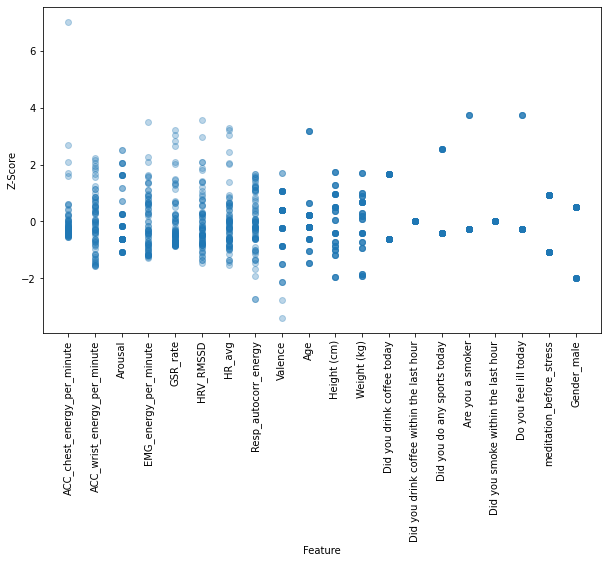

In [117]:
x_nums = np.array(list(range(scaled_X.shape[1])) * scaled_X.shape[0])
plt.figure(figsize=[10, 6])
plt.scatter(x=x_nums, y=scaled_X.flatten(),alpha=0.3)
plt.xticks(range(scaled_X.shape[1]), labels=X_cols.columns, rotation=90)
plt.ylabel('Z-Score')
plt.xlabel('Feature')
plt.show()

# Train-test split

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(52, 20) (23, 20) (52,) (23,)


# I want to see if a random forest works.

In [126]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(random_forest, X_train, y_train, cv=3) #Dataset is currently small, so 3-fold cv.

print('cv_scores:', cv_scores)
print('mean of cv_scores', np.mean(cv_scores))

cv_scores: [0.83333333 0.88235294 0.76470588]
mean of cv_scores 0.8267973856209151


In [131]:
# Curious about predictions within training set

#random_forest.fit(X_train, y_train)
#predictions = random_forest.predict(X_train)
#display(pd.DataFrame(dict(predictions=predictions, actual=y_train)))

from sklearn.model_selection import cross_val_predict
cv_predictions = cross_val_predict(RandomForestClassifier(), X_train, y_train, cv=3) #Dataset is currently small, so 3-fold cv.
pred_actual_df = pd.DataFrame(dict(cv_predictions=cv_predictions, actual=y_train))
for value in pred_actual_df.actual.unique():
    within_class_accuracy = np.mean(pred_actual_df.actual.loc[pred_actual_df.actual == value] == pred_actual_df.cv_predictions.loc[pred_actual_df.actual == value])
    print(value, str(np.round(within_class_accuracy * 100))+'%')
display(pred_actual_df.sort_values('actual'))


SOCIAL STRESS 100.0%
AMUSEMENT 40.0%
MEDITATION 96.0%
BASELINE 91.0%


,cv_predictions,actual
45,MEDITATION,AMUSEMENT
30,AMUSEMENT,AMUSEMENT
15,AMUSEMENT,AMUSEMENT
60,MEDITATION,AMUSEMENT
20,MEDITATION,AMUSEMENT
55,BASELINE,AMUSEMENT
50,MEDITATION,AMUSEMENT
25,AMUSEMENT,AMUSEMENT
70,AMUSEMENT,AMUSEMENT
65,BASELINE,AMUSEMENT


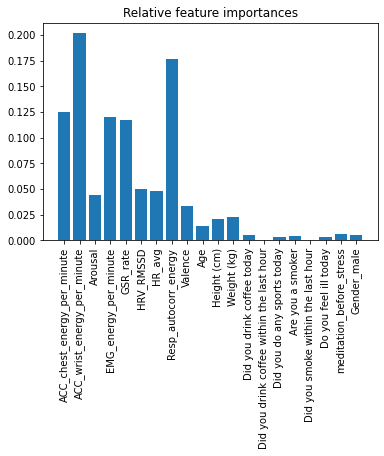

In [138]:
rand_forest = RandomForestClassifier(random_state=123)
rand_forest.fit(X_train, y_train)
plt.bar(x=range(len(rand_forest.feature_importances_)), height=rand_forest.feature_importances_)
plt.xticks(range(len(rand_forest.feature_importances_)), labels=X_cols.columns,rotation=90)
plt.title('Relative feature importances')
plt.show()

# Interesting. The important features reflect movement related features, skin conductance (sweating), and respiration (which makes sense because the meditation is guided paced-breathing)